In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
import openpathsampling as paths
import numpy as np
import itertools as itt


def ops_load_trajectory(filename, top=None):
    return paths.engines.openmm.tools.trajectory_from_mdtraj(md.load(filename, top=top))

In [2]:
source = 'trajectory'
run = 'run2'
if source == 'test':
    current_dir = '/home/sanderroet/scripts/test_show/'
if source == 'vreede':
    current_dir = '/home/sanderroet/Ras-JV/'+run+'/analysis/'
    name = 'vreede_'+run
elif source == 'carbon':
    current_dir = '/home/sanderroet/carbon/kras_100ns/'+run+'/analysis/'
    name = 'carbon_'+run
elif source == 'cartesius':
    current_dir = '/home/sanderroet/cartesius/vreede_'+run+\
                  '_continue/analysis/'
    name = 'vreede_'+run+'_continue'
elif source == 'vreede_continue':
    current_dir = '/home/sanderroet/Ras-JV/'+run+'/analysis/continue/'
    name = 'vreede_'+run
elif source == 'carbon_continue':
    current_dir = '/home/sanderroet/cartesius/carbon_'+run+'_continue/analysis/'
    name = source+'_'+run

elif source == 'trajectory':
    current_dir = '/home/sanderroet/ras-transition/'+run+'/analysis/'
    name = source+'_'+run

xtc = current_dir + 'vis-md.xtc'
pdb = current_dir + 'vis-md.pdb'

In [3]:
run = ops_load_trajectory(xtc, top=pdb)
topology = run.topology.md

In [4]:
gly60 = topology.select('protein and (resSeq 60)')                   
gly12 = topology.select('protein and (resSeq 12)')                   
gln61 = topology.select('protein and resSeq 61 and not backbone and not name H')
arg68 = topology.select('protein and resSeq 68 and name O')          
met72 = topology.select('protein and resSeq 72 and name H')          
GTP = topology.select('((resname GTP) and not element H) or element Mg')
GTP_COM = topology.select('resname GTP or element Mg')
glu63 = topology.select('protein and (resSeq 63) and name CG')       
glu62 = topology.select('protein and (resSeq 62) and name CG')       
switch2_COM = topology.select('protein and(resSeq 61 to 66)')

print (GTP_COM)

[2626 2627 2628 2629 2630 2631 2632 2633 2634 2635 2636 2637 2638 2639 2640
 2641 2642 2643 2644 2645 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655
 2656 2657 2658 2659 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670]


In [21]:
def min_distance(snapshot, pair):
    import mdtraj as md
    import itertools as itt
    pair_list = list(itt.product(pair[0],pair[1]))
    snapshot = paths.Trajectory(snapshot).md()
    distance = md.compute_distances(snapshot, pair_list)
    result = []
    for i in distance:
        result.append(min(i))
    return result

def COM_distance(snapshot, pair):
    import mdtraj as md
    trj = paths.Trajectory(snapshot).md()
    set0_trj = trj.atom_slice(pair[0])
    set1_trj = trj.atom_slice(pair[1])
    set0_center = md.compute_center_of_mass(set0_trj)
    set1_center = md.compute_center_of_mass(set1_trj)
    distances = set0_center-set1_center
    result = []
    for i in distances:
        result.append(((i[0]**2) + (i[1]**2) + (i[2]**2))**0.5)
    return result

d_gly60_gly12 = paths.CV_Function("d_gly60_gly12", min_distance, pair = [gly60, gly12], cv_requires_lists = True)
d_gln61_gly12 = paths.CV_Function("d_gln61_gly12", min_distance, pair = [gln61, gly12], cv_requires_lists = True)
d_glu62_GTP   = paths.CV_Function("d_glu62_GTP"  , min_distance, pair = [glu62, GTP], cv_requires_lists = True)
d_glu63_GTP   = paths.CV_Function("d_glu63_GTP"  , min_distance, pair = [glu63, GTP], cv_requires_lists = True)
d_arg68_met72 = paths.CV_Function("d_arg68_met72", min_distance, pair = [arg68, met72], cv_requires_lists = True)
d_COM_S2_GTP  = paths.CV_Function("d_COM_S2_GTP" , COM_distance, pair = [GTP_COM, switch2_COM], cv_requires_lists = True)

In [22]:
print min_distance(run[], [gly60, gly12])

[0.6806221]


In [7]:
state_open = (paths.CVRangeVolume(d_gly60_gly12, lambda_min=0.6, lambda_max=5.0) &
              paths.CVRangeVolume(d_gln61_gly12, lambda_min=0.8, lambda_max=5.0) &
              paths.CVRangeVolume(d_glu62_GTP, lambda_min=1.0, lambda_max=5.0) &
              paths.CVRangeVolume(d_glu63_GTP, lambda_min=1.0, lambda_max=5.0) &
              paths.CVRangeVolume(d_COM_S2_GTP, lambda_min=1.975, lambda_max=5.0)).named('Open')

state_closed =((paths.CVRangeVolume(d_gly60_gly12, lambda_min=0.0, lambda_max=0.3) |
               paths.CVRangeVolume(d_gln61_gly12, lambda_min=0.0, lambda_max=0.3) |
               paths.CVRangeVolume(d_glu62_GTP, lambda_min=0.0, lambda_max=0.65) |
               paths.CVRangeVolume(d_glu63_GTP, lambda_min=0.0, lambda_max=0.65)) &
               paths.CVRangeVolume(d_COM_S2_GTP, lambda_min=0.0, lambda_max=1.6)).named('Closed')


CPU times: user 2.89 s, sys: 5.73 s, total: 8.62 s
Wall time: 8.64 s


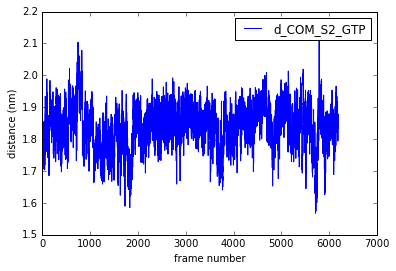

In [8]:
%%time
variable_list = [
                 d_gly60_gly12,
                 d_gln61_gly12,
                 d_glu62_GTP,
                 d_glu63_GTP,
                 d_arg68_met72,
                 d_COM_S2_GTP,
                ]
for i, e in enumerate(variable_list):
    data = e(run)
    if e.name == 'd_COM_S2_GTP':
        fig = plt.figure()
        (plot_line,) = plt.plot(data, label=e.name)
        plt.xlabel('frame number')
        plt.ylabel('distance (nm)')
        plt.legend(handles=[plot_line]);


In [9]:
%%time
n_frames_open = 0
frames_open = [frame for frame in run if state_open(frame)]
n_frames_closed = 0
frames_closed = [frame for frame in run if state_closed(frame)]
n_frames_out = 0
n_frames_both = 0
i = 0
for s in run:
    s_open = False
    s_closed = False
    if state_open(s) == True:
        s_open = True
    if state_closed(s) == True:
        s_closed = True
        print(i)
    if s_open == True and s_closed == False:
        n_frames_open += 1
    elif s_open == False and s_closed == True:
        n_frames_closed += 1
    elif s_open == False and s_closed == False:
        n_frames_out += 1
    elif s_open == True and s_closed == True:
        n_frames_both += 1
    i += 1
n_frames = len(run)
print "Frames in open state:  " + str(n_frames_open) + "/" + str(n_frames)
print "Frames in closed state:  " + str(n_frames_closed) + "/" + str(n_frames)
print "Frames not in a state:  " + str(n_frames_out) + "/" + str(n_frames)
print "Frames in both states:  " + str(n_frames_both) + "/" + str(n_frames)

5712
5714
5723
Frames in open state:  47/6183
Frames in closed state:  3/6183
Frames not in a state:  6133/6183
Frames in both states:  0/6183
CPU times: user 2.04 s, sys: 38.5 ms, total: 2.08 s
Wall time: 2.04 s


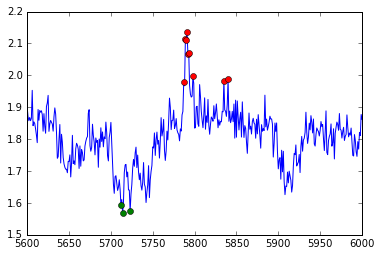

In [24]:
for e in [d_COM_S2_GTP]:
    fig =plt.figure()
    plt.plot(e(run))
    input_index = [run.index(s) for s in frames_open]
    plt.plot(input_index, e(run[input_index]), 'ro')
    input_index = [run.index(s) for s in frames_closed]
    plt.plot(input_index, e(run[input_index]), 'go')
    plt.xlim([5600,6000])

In [11]:
%%time
c_o = paths.TISTransition(stateA=state_closed,
                          stateB=state_open,
                          interfaces=[state_closed],
                          orderparameter=d_COM_S2_GTP)
analyzer = paths.SingleTrajectoryAnalysis(c_o,dt = 10).analyze(run)

CPU times: user 50.3 s, sys: 188 ms, total: 50.5 s
Wall time: 50.3 s


In [12]:
%%time
flux_out_closed = analyzer.analyze_flux(trajectory = run,
                                        state = state_closed,
                                        interface = state_closed)['out']
flux_out_open = analyzer.analyze_flux(trajectory = run,
                                        state = state_open,
                                        interface = state_open)['out']
flux_in_closed = analyzer.analyze_flux(trajectory = run,
                                        state = state_closed,
                                        interface = state_closed)['in']

flux_in_open = analyzer.analyze_flux(trajectory = run,
                                        state = state_open,
                                        interface = state_open)['in']
print "flux events out of the closed interface: "+str(len(flux_out_closed))+"\n"

print "flux events out of the open interface: "+str(len(flux_out_open))+"\n"


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,6))
#plt.hist([len(traj) for traj in flux_out_closed])
plt.figure(figsize=(12,6))
plt.hist([len(traj) for traj in flux_out_closed], bins=range(1, 20, 1))
plt.figure(figsize=(12,6))
#plt.hist([len(traj) for traj in flux_in_closed])
plt.figure(figsize=(12,6))
plt.hist([len(traj) for traj in flux_in_closed], bins=range(1, 20, 1))

In [ ]:
plt.figure(figsize=(12,6))
#plt.hist([len(traj) for traj in flux_out_open])
plt.figure(figsize=(12,6))
plt.hist([len(traj) for traj in flux_out_open], bins=range(1, 200, 1))
plt.figure(figsize=(12,6))
#plt.hist([len(traj) for traj in flux_in_open])
plt.figure(figsize=(12,6))
plt.hist([len(traj) for traj in flux_in_open], bins=range(1, 200, 1))

In [ ]:
open_lifetime = analyzer.analyze_lifetime(run, state_open)
for i in open_lifetime:
    print len(i)

In [ ]:
list_flux_out_closed = [len(x)*analyzer.dt for x in analyzer.flux_segments[state_closed]['out']]
list_flux_in_closed =  [len(x)*analyzer.dt for x in analyzer.flux_segments[state_closed]['in']]
flux_closed =1.0/(np.mean(list_flux_out_closed) + np.mean(list_flux_in_closed))
print "flux closed interface = "+str(flux_closed) +" /ps"
print "flux closed interface = "+str(flux_closed*1000) +" /ns\n"

list_flux_out_open = [len(x)*analyzer.dt for x in analyzer.flux_segments[state_open]['out']]
list_flux_in_open =  [len(x)*analyzer.dt for x in analyzer.flux_segments[state_open]['in']]
flux_open =1.0/(np.mean(list_flux_out_open) + np.mean(list_flux_in_open))
print "flux open interface = "+str(flux_open) +" /ps"
print "flux open interface = "+str(flux_open*1000) +" /ns"